# Tema 26: Modelos Mixtos

En la libreta previa exploramos cómo realizar un análisis de varianza de medidas repetidas en el dataset de `sleepstudy`, y comentamos que este dataset es muy utilizado para ejemplificar el uso y ventajas de los modelos mixtos o jerárquicos.
 
## Librerías y datos

In [23]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
# !pip install pingouin -q # quita este comentario si estás en colab
import pingouin as pg
dataset = sm.datasets.get_rdataset('sleepstudy', package='lme4')
print("Librerías importadas y datset descargado")

Librerías importadas y datset descargado


Exploremos qué información adicional nos da statsmodels sobre este dataset.

In [18]:
dataset.title

'Reaction times in a sleep deprivation study'

In [13]:
dataset.package

'lme4'

También podemos ver la documentación propia de R para este dataset.

In [19]:
print(dataset.__doc__)

.. container::

   .. container::

      ========== ===============
      sleepstudy R Documentation
      ========== ===============

      .. rubric:: Reaction times in a sleep deprivation study
         :name: reaction-times-in-a-sleep-deprivation-study

      .. rubric:: Description
         :name: description

      The average reaction time per day (in milliseconds) for subjects
      in a sleep deprivation study.

      Days 0-1 were adaptation and training (T1/T2), day 2 was baseline
      (B); sleep deprivation started after day 2.

      .. rubric:: Format
         :name: format

      A data frame with 180 observations on the following 3 variables.

      ``Reaction``
         Average reaction time (ms)

      ``Days``
         Number of days of sleep deprivation

      ``Subject``
         Subject number on which the observation was made.

      .. rubric:: Details
         :name: details

      These data are from the study described in Belenky et al. (2003),
      for the

### Datos
Para acceder a los datos utilizamos el atributo `data`-

In [20]:
data = dataset.data
data.head()

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308


## Modelo
Modelaremos la relación entre los días de deprivación de sueño y el tiempo de reacción permitiendo una pendiente aleatoria para cada sujeto a lo largo del tiempo.

### Interceptos aleatorios

In [22]:
model = sm.MixedLM.from_formula(
    'Reaction ~ Days',
    data=data,
    groups='Subject', # intercepto aleatorio
)

result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Reaction 
No. Observations:  180      Method:              REML     
No. Groups:        18       Scale:               960.4568 
Min. group size:   10       Log-Likelihood:      -893.2325
Max. group size:   10       Converged:           Yes      
Mean group size:   10.0                                   
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    251.405    9.747 25.794 0.000 232.302 270.508
Days          10.467    0.804 13.015 0.000   8.891  12.044
Subject Var 1378.176   17.156                             



En este modelo estamos permitiendo que cada sujeto varíe su intercepto, es decir, ajustamos el modelo para el tiempo de reacción de cada sujeto al momento cero.

Si analizamos lo resultados, vemos que el intercepto es `251.405`, este es el promedio del tiempo de reacción de los sujetos antes de la deprivación de sueño, es decir al momento cero. El coeficiente de `Days` es `10.467` es decir, que en promedio, cada día de deprivación, aumentó el tiempo de reacción en 10 ms.

Este modelo, sin embargo, no considera que cada sujeto responde de forma diferente a la deprivación, algunos sujetos parecen aumentar más o menos su tiempo de reacción conforme pasan los días. Veamos la siguiente figura.

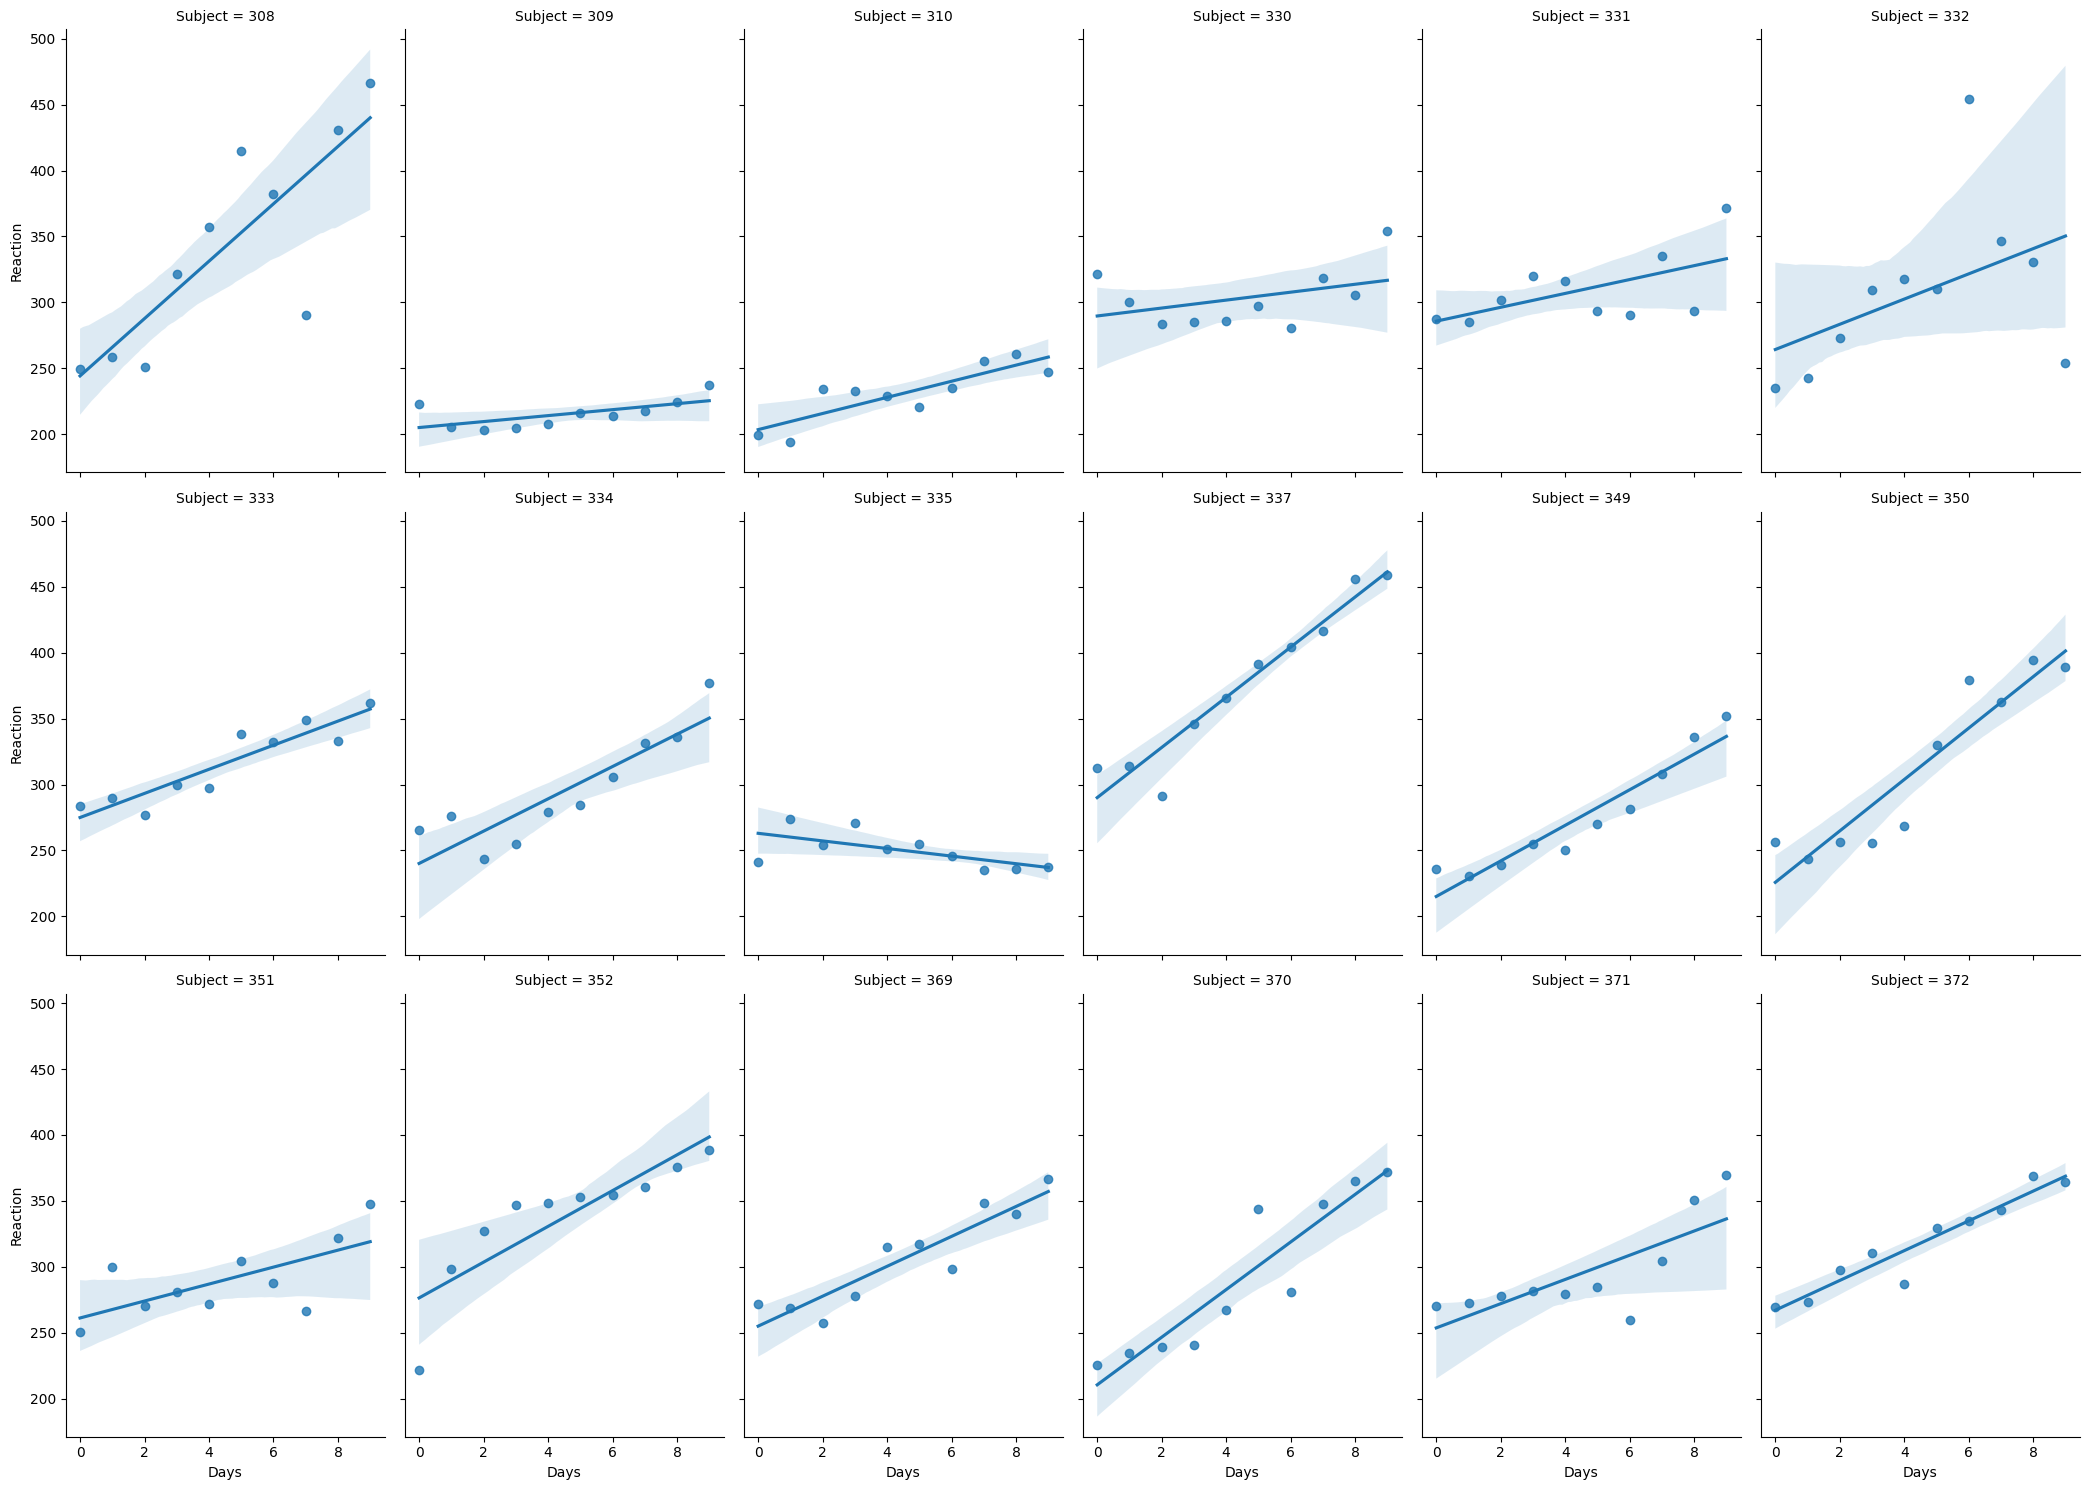

In [24]:
sns.lmplot(
    data,
    x='Days',
    y='Reaction',
    col='Subject',
    col_wrap=6,
    aspect=0.7,
)

Para poder contemplar la pendiente de cada sujeto en el modelo, debemos agregar una pendiente aleatoria, en statsmodels se ve así:

In [25]:
model2 = sm.MixedLM.from_formula(
    'Reaction ~ Days',
    data=data,
    groups='Subject', # intercepto aleatorio
    re_formula='~ Days', # pendiente aleatoria (Days|Subject)
)

result = model2.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Reaction 
No. Observations:    180        Method:                REML     
No. Groups:          18         Scale:                 654.9405 
Min. group size:     10         Log-Likelihood:        -871.8141
Max. group size:     10         Converged:             Yes      
Mean group size:     10.0                                       
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          251.405    6.825 36.838 0.000 238.029 264.781
Days                10.467    1.546  6.771 0.000   7.438  13.497
Subject Var        612.096   11.881                             
Subject x Days Cov   9.605    1.821                             
Days Var            35.072    0.610                             

